In [2]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import inspect
import matplotlib.pyplot as plt


In [3]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [4]:
Base = automap_base()
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


/var/folders/qq/btq3mm09773cwl69pjm3kzf40000gn/T/ipykernel_58085/495836085.py:2: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [5]:
session = Session(engine)


In [6]:
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent_date)


('2017-08-23',)


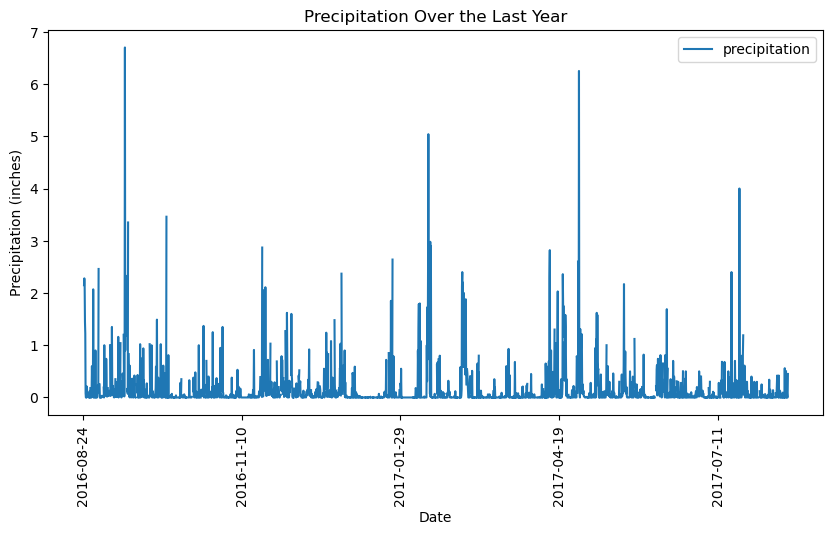

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


In [7]:
from datetime import datetime, timedelta

last_date = datetime.strptime(most_recent_date[0], "%Y-%m-%d")
one_year_ago = last_date - timedelta(days=365)

precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Load into DataFrame
prcp_df = pd.DataFrame(precipitation_data, columns=["date", "precipitation"])
prcp_df = prcp_df.sort_values(by="date")

# Plot the results
prcp_df.plot(x="date", y="precipitation", figsize=(10,5))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last Year")
plt.xticks(rotation=90)
plt.show()

# Print summary statistics
print(prcp_df.describe())


In [8]:
session.close()


In [9]:
station_count = session.query(func.count(Station.station)).all()
print(station_count)


[(9,)]


In [10]:
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
print(active_stations)


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


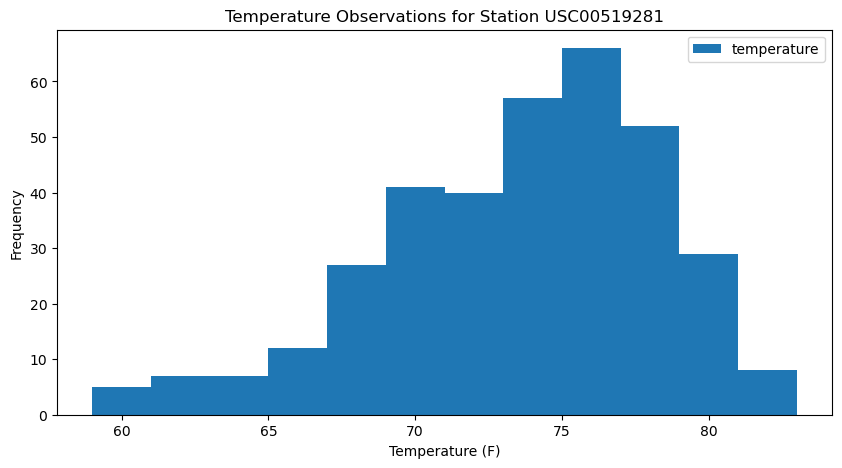

In [11]:
most_active_station = active_stations[0][0]

tobs_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()

# Load into DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["date", "temperature"])

# Plot the histogram
tobs_df.plot.hist(bins=12, figsize=(10,5))
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.title(f"Temperature Observations for Station {most_active_station}")
plt.show()


In [12]:
from flask import Flask, jsonify
from sqlalchemy import create_engine, func
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
import numpy as np
import datetime as dt


In [13]:
app = Flask(__name__)

engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base = automap_base()
Base.prepare(engine, reflect=True)

Measurement = Base.classes.measurement
Station = Base.classes.station

@app.route("/")
def welcome():
    return (
        f"Welcome to the Climate API!<br/>"
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end><br/>"
    )


/var/folders/qq/btq3mm09773cwl69pjm3kzf40000gn/T/ipykernel_58085/3294328932.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [14]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    session = Session(engine)
    most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    last_date = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d")
    one_year_ago = last_date - dt.timedelta(days=365)

    precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()
    session.close()

    precipitation_dict = {date: prcp for date, prcp in precipitation_data}
    return jsonify(precipitation_dict)


In [15]:
# Route for stations data
@app.route("/api/v1.0/stations")
def stations():
    session = Session(engine)
    stations_result = session.query(Station.station).all()
    session.close()

    # Convert list of tuples into normal list
    stations_list = list(np.ravel(stations_result))
    return jsonify(stations_list)

# Route for temperature observations (tobs) of the most active station for the last year
@app.route("/api/v1.0/tobs")
def tobs():
    session = Session(engine)
    most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
    last_date = dt.datetime.strptime(most_recent_date[0], "%Y-%m-%d")
    one_year_ago = last_date - dt.timedelta(days=365)

    # Find the most active station
    most_active_station = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()[0]

    # Query the last year of temperature data for the most active station
    tobs_data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == most_active_station).filter(Measurement.date >= one_year_ago).all()
    session.close()

    # Convert query results into a list
    tobs_list = list(np.ravel(tobs_data))
    return jsonify(tobs_list)

# Route to return min, max, and avg temperature from the start date
@app.route("/api/v1.0/<start>")
def start_date(start):
    session = Session(engine)
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start).all()
    session.close()

    # Convert the result into a dictionary
    temp_dict = {
        "TMIN": results[0][0],
        "TAVG": results[0][1],
        "TMAX": results[0][2]
    }
    return jsonify(temp_dict)

# Route to return min, max, and avg temperature for a date range (start to end)
@app.route("/api/v1.0/<start>/<end>")
def start_end_date(start, end):
    session = Session(engine)
    results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).filter(Measurement.date >= start).filter(Measurement.date <= end).all()
    session.close()

    # Convert the result into a dictionary
    temp_dict = {
        "TMIN": results[0][0],
        "TAVG": results[0][1],
        "TMAX": results[0][2]
    }
    return jsonify(temp_dict)

# Run the Flask application
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/opt/anaconda3/lib/python3.12/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/opt/anaconda3/lib/python3.12/site-packages/traitlets/config/application.py", line 118, in inner
    return method(app, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

SystemExit: 1

/opt/anaconda3/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
